In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        #find best action
        best_action = np.argmax(np.array(Q[observation]))
        #assign epsilon/nr_actions probability to all actions
        probs = np.ones([nA]) * epsilon/nA
        #increase the probabilty of the best action by 1- epsilon
        probs[best_action] += 1 - epsilon
        return probs
    return policy_fn

In [18]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    
    def return_following_state(episode, discount_factor=discount_factor):
        """returns the total discounted reward in the sequence, sums over the list of the mapping of a *dicount_factor**step"""
        rewards = np.array([episode_tuple[2] for episode_tuple in episode])
        discounted_rewards = list(map(lambda index, reward: reward * (discount_factor**index) ,range(len(rewards)) ,rewards))
        return np.sum(discounted_rewards)
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        #generate an episode
        episode = []
        observation = env.reset()
        done = False
        while not done:
            action = np.random.choice(a=list(range(env.nA)), p=policy(observation))
            new_observation , reward, done, _ = env.step(action)
            episode.append((observation, action, reward, new_observation))
            observation = new_observation       
            
        #find all state_action pairs
        state_action_pairs = [(episode_tuple[0],episode_tuple[1]) for episode_tuple in episode]
    
        # for each state action pair increase the counter as well as the sum, 
        # and then compute the q value
        for index, (state, action) in enumerate(state_action_pairs):
                returns_count[(state,action)] += 1
                returns_sum[(state,action)] += return_following_state(episode[index:])
                Q[state][action] = returns_sum[(state,action)] / returns_count[(state,action)]
    
        #update the policy according to the new q values
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    return Q, policy

In [21]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)

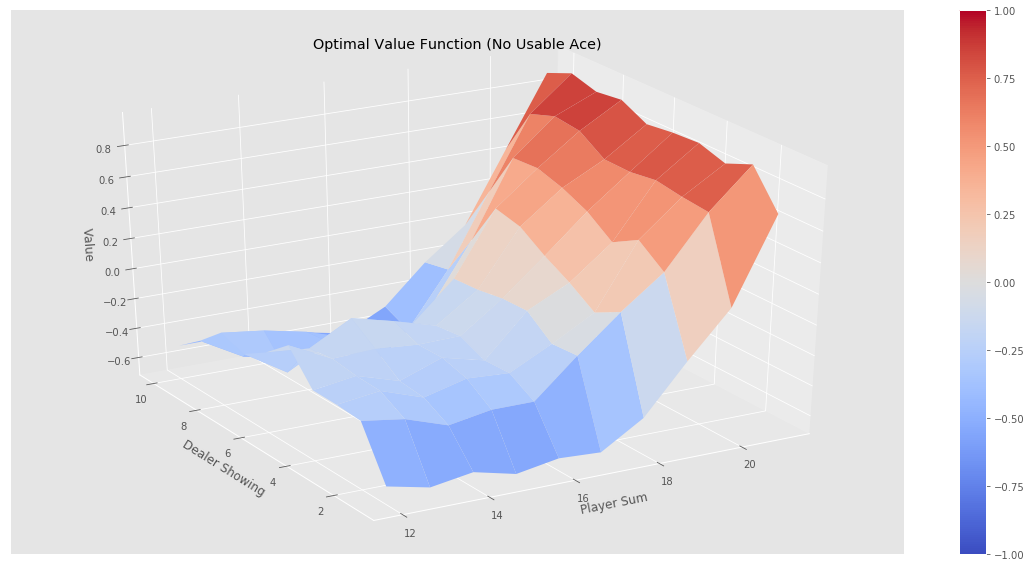

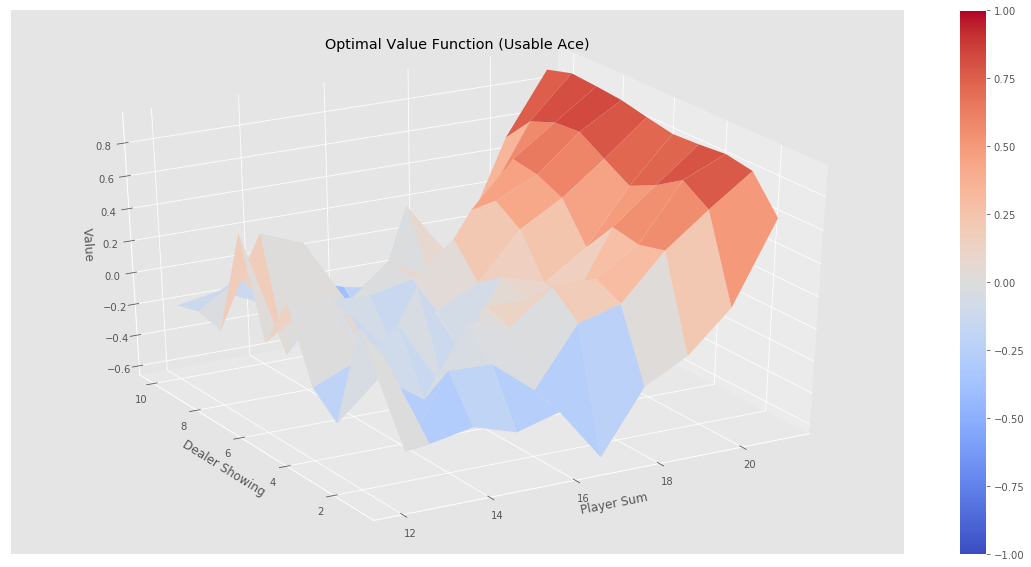

In [22]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [2]:
??plotting.plot_value_function